# Somatic Instability Analysis

**Author:** Ramita Dewan <br>
**Last edited:** 09-22-20 <br>

*Method used to calculate Instability Indices:* as reported in Pinto et al., 2020 <br>
https://pubmed.ncbi.nlm.nih.gov/32761094/

## Table of Contents:
* [Notes](#Notes)
* [Calculate Instability Indices](#instability_indices)
* [Create Plots](#create_plots)

## Notes <a class="anchor" id="Notes"></a>
### Files needed:
1. Sample key (tab-delimited .txt file) containing the following columns (no heading) for each region (separate file for each sample): <br>
    - File path for peak tables (.txt) direct output files from GeneMapper (4.0)<br>
    - Region name
    - Modal peak height (manual verification based on observation of peak table and chromatogram)
    - Modal peak size (manual verification based on observation of peak table and chromatogram) <br>
2.  Heatmap input dataframe (tab-delimited .txt file) containing the following columns (no heading): <br>
    - Sample name that region corresponds to
    - Region name
    - Instability index for corresponding region

## Calculate Instability Indices <a class="anchor" id="instability_indices"></a>


In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import glob
import matplotlib
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [11]:
# Set default matplotlib parameters

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
def extract_files(sample_df):
    """Use the input parameter 'sample_df' to read individual sample dataframes, and return a list of dataframes 
    with desired column names."""
    
    df_list = []
    file_list = sample_df.iloc[:,0]
    sampleID_list = sample_df.iloc[:,1]
    
    for item in range(len(file_list)):
        df_list.append(pd.read_csv(file_list[item], delimiter='\t'))
        df_list[item] = df_list[item][['Sample File Name','Size','Height','Area','Data Point']]
        df_list[item].columns = ['Sample_Name','Size','Height','Area','Data_Point']
        df_list[item]['Sample_Name'] = sampleID_list[item]
    
    return df_list

def exp_peak_subset(sample_df, extracted_files):
    """Use the input parameter 'sample_df' to read the height and size responding to the modal peak for each
    sample, and then select all expansion peaks using the input parameter 'extracted_files'. The expansion peaks
    are returned as a list of dataframes in 'sample_subset', as well as a list of modal heights for all samples."""
    
    modal_height = sample_df.iloc[:,2].tolist()
    modal_size = sample_df.iloc[:,3].tolist()
    
    relative_threshold = []
    sample_subset = []
    
    for item in range(len(modal_height)):
        relative_threshold.append((modal_height[item]*0.01))
        sample_subset.append(extracted_files[item][(extracted_files[item].Height >= relative_threshold[item]) & 
                                                   (extracted_files[item].Height <= modal_height[item]) &
                                                   (extracted_files[item].Size > modal_size[item])])
    
    return sample_subset, modal_height

def calc_instability_index(peak_subset_list, modal_height):
    """Use the list of expansion peaks for each sample, received as the input parameter 'peak_subset_list', as
    well as the modal heights for each sample, received as the input parameter 'modal_height', to calculate the
    instability index for each sample, returned as the list 'instability_index'. The modified 'peak_subset_list'
    is also returned, with columns for normalized_Height, change_from_main, and normalized_Peak."""
    
    # Calculate sum of heights of all peaks in subset  
    height_sum = []
    
    for item in range(len(peak_subset_list)):
        height_sum.append(peak_subset_list[item].Height.sum() + modal_height[item])
        peak_subset_list[item]['normalized_Height'] = round(peak_subset_list[item].Height/height_sum[item],3)

    # Create change from main
    for item in range(len(peak_subset_list)):
        for ii,row in peak_subset_list[item].iterrows():
            maxHeightIndex = peak_subset_list[item].Height.idxmax()
            currentHeight = peak_subset_list[item].loc[ii,'Height']
            currentIndex = (peak_subset_list[item][peak_subset_list[item]['Height'] == 
                                                   currentHeight].index.values.astype(int)[0])
            peak_subset_list[item].at[ii,'change_from_main'] = currentIndex - maxHeightIndex + 1

    # Calculate and create new column for normalized peak 
    # (normalized peak = normalized height * change from main)
    for item in range(len(peak_subset_list)):
        for ii,row in peak_subset_list[item].iterrows():
            peak_subset_list[item].at[ii,'normalized_Peak'] = round(peak_subset_list[item].at[ii,'normalized_Height'] * peak_subset_list[item].at[ii, 'change_from_main'],3)

    # Calculate instability index
    instability_index = []

    for item in range(len(peak_subset_list)):
        instabilityValue = round(peak_subset_list[item].normalized_Peak.sum(),3)
        instability_index.append(instabilityValue)
            
    return peak_subset_list, instability_index

In [6]:
# Read input sample list
PT8_input = pd.read_csv('Input/PT8_input.txt', delimiter='\t', header=None)
PT5_input = pd.read_csv('Input/PT5_input.txt', delimiter='\t', header=None)
HD_PT_input = pd.read_csv('Input/HD_PT_input.txt', delimiter='\t', header=None)

# Extract files
PT8_samples = extract_files(PT8_input)
PT5_samples = extract_files(PT5_input)
HD_PT_samples = extract_files(HD_PT_input)

# Subset sample files to include expanded peaks only
PT8_exp_peaks, PT8_modal_height = exp_peak_subset(PT8_input, PT8_samples)
PT5_exp_peaks, PT5_modal_height = exp_peak_subset(PT5_input, PT5_samples)
HD_PT_exp_peaks, HD_PT_modal_height = exp_peak_subset(HD_PT_input, HD_PT_samples)

# Calculate instability indices
PT8_final_exp_peaks, PT8_instability_indices = calc_instability_index(PT8_exp_peaks, PT8_modal_height)
PT5_final_exp_peaks, PT5_instability_indices = calc_instability_index(PT5_exp_peaks, PT5_modal_height)
HD_PT_final_exp_peaks, HD_PT_instability_indices = calc_instability_index(HD_PT_exp_peaks, HD_PT_modal_height)

/Users/dewanr2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dewanr2/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dewanr2/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Example output

In [7]:
display(PT8_instability_indices)

[0.566,
 0.423,
 0.283,
 0.689,
 0.59,
 0.293,
 0.286,
 0.385,
 0.237,
 0.7,
 0.42,
 0.349,
 0.343,
 0.395,
 0.465,
 0.628,
 0.496,
 0.522,
 0.716,
 0.636,
 0.492,
 0.502]

## Create plots <a class="anchor" id="create_plots"></a>

### Individual sample bar charts

In [17]:
def create_ind_plot(input_df, instability_indices, plot_title, save_name):
    """Create individual sample bar charts. Input parameter 'input_df' is the same input file used for somatic
    instability analysis. """
    
    # Extract region names
    sample_names = input_df.iloc[:,1].tolist()
    
    # Create sorted dataframe of regions and corresponding instability indices
    plot_dict = {'Regions':sample_names, 'InstabilityIndices': instability_indices}
    plotdf = pd.DataFrame(plot_dict)
    plotdf_ordered = plotdf.sort_values(by=['InstabilityIndices'], ascending=False).copy()

    # Create plot
    ax = plotdf_ordered.plot.bar(x='Regions', y='InstabilityIndices', color="#7878ff", edgecolor='#929591',
                                 linewidth=1.2, figsize=(8,7))
    plt.ylabel('Expansion Index')
    plt.xlabel('')
    plt.title(plot_title)
    plt.xticks(rotation=45, ha='right') 
    ax.get_legend().remove()

    plt.show()
    #plt.savefig('Output/'+save_name+'_092220.png', bbox_inches='tight')
    plt.clf()

Example output

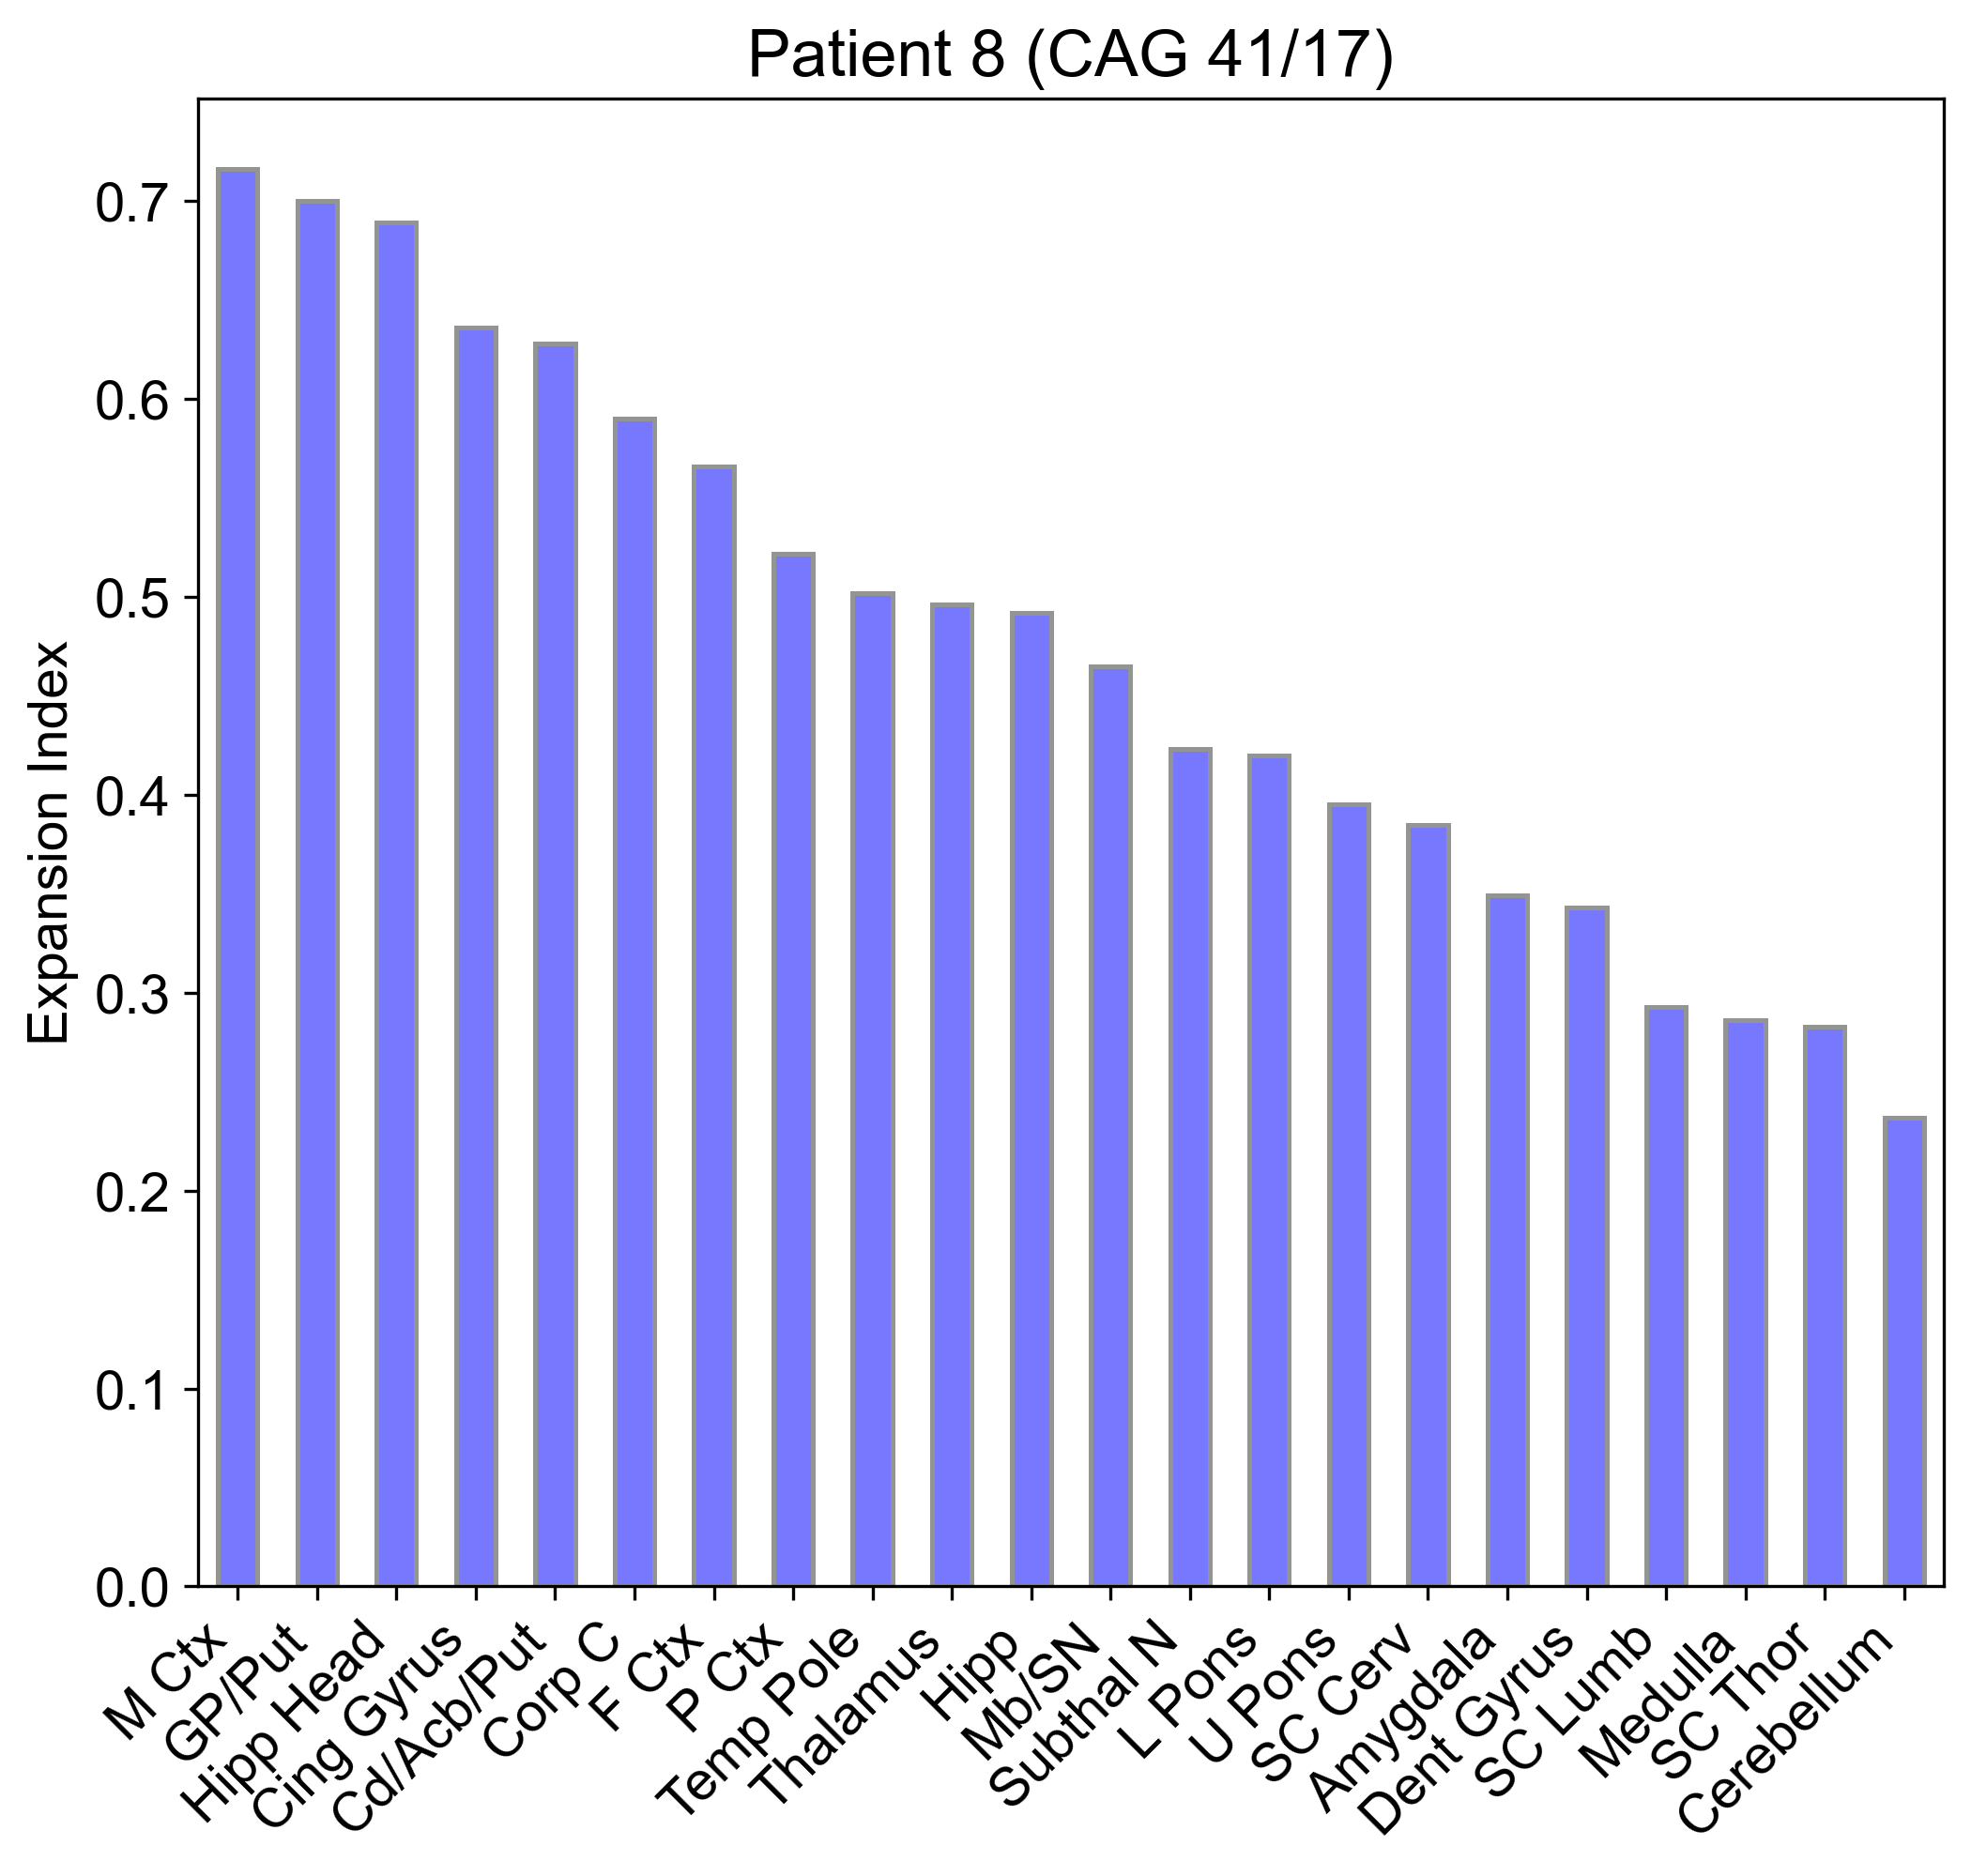

<Figure size 1800x1200 with 0 Axes>

In [18]:
create_ind_plot(PT8_input, PT8_instability_indices, 'Patient 8 (CAG 41/17)', 'PT8')
#create_ind_plot(PT5_input, PT5_instability_indices, 'Patient 5 (CAG 40/15)', 'PT5')
#create_ind_plot(HD_PT_input, HD_PT_instability_indices, 'HD Patient (CAG 41/17)', 'HD_PT')

### Heatmap of aggregate instability indices

In [13]:
# Read heatmap_dataset input dataframe
heatmap_dataset = pd.read_csv('Input/ranking_input.txt', delimiter='\t', header=None)
heatmap_dataset.columns = ['Patient','Region','Value']

# Clean up heatmap_dataset
pts = ['PT_5', 'PT_8', 'HD_PT']
pts_type = CategoricalDtype(categories=pts, ordered=True)
heatmap_dataset["Patient"] = heatmap_dataset["Patient"].astype(pts_type)

# Create sorted pivot table
heatmap_pivot = pd.pivot_table(heatmap_dataset, index=['Region'], columns = ['Patient'], values=['Value'], 
                                dropna = False, margins=True)
heatmap_pivot = heatmap_pivot.iloc[:-1]
heatmap_pivot.sort_values(by=('Value','All'), ascending=False, inplace=True)  # sort by row sum
heatmap_final = heatmap_pivot.iloc[:, :-1]

/Users/dewanr2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


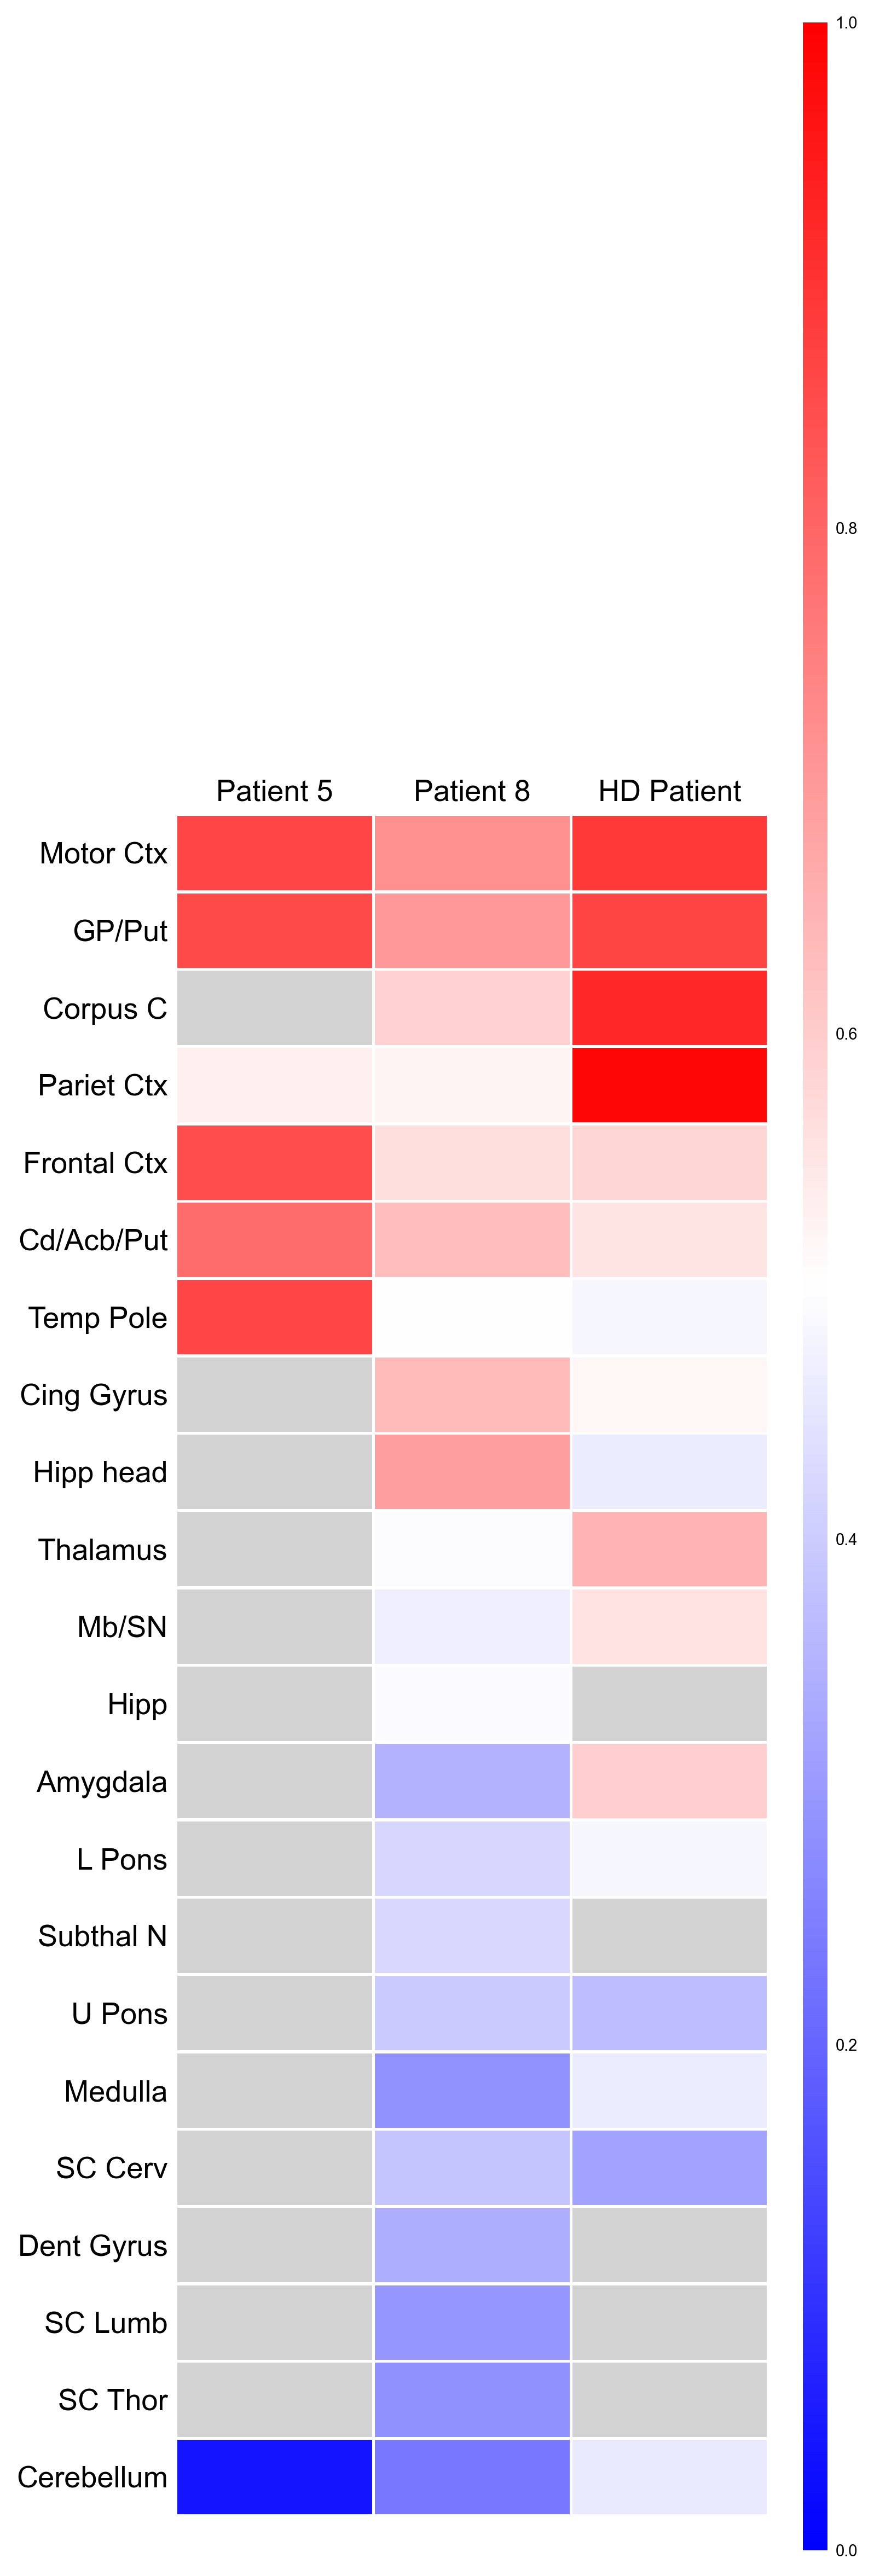

<Figure size 1800x1200 with 0 Axes>

In [14]:
# Create figure
fig, ax = plt.subplots(figsize = (5,11), dpi=300)

# Create separate axis for color bar
cbar_ax = fig.add_axes([1.0,0,.03,1.4])
cbar_ax.tick_params(labelbottom=False, labeltop=False, length = 0, labelsize = 7)
cbar_ax.set_yticks([])
cbar_ax.set_xticks([])

# Create heatmap
x_axis_labels = ['Patient 5','Patient 8', 'HD Patient'] # set labels for x-axis
sns.heatmap(heatmap_final, cbar=True, linecolor="w", cmap = 'bwr', linewidths=1, xticklabels=x_axis_labels,
           ax=ax, vmin=0, vmax=1, cbar_ax = cbar_ax, mask=heatmap_final.isnull()) 
ax.set_facecolor('lightgray')

# Move X axis labels to top
ax.tick_params(labelbottom=False, labeltop=True, length = 0, labelsize = 13)

# Remove axes titles
ax.set_ylabel('')    
ax.set_xlabel('')

plt.tight_layout()
#plt.savefig('/Users/dewanr2/Documents/Ramitas_Docs/Genetic_Screens/HTT/Somatic_Instability/Output/ranking_plot_091620_abbrev.png', bbox_inches='tight')
plt.show()
plt.clf()